In [42]:
# define necessary imports
import numpy as np
import os
import tensorflow as tf
from keras import models, layers
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [43]:
# Load the CIFAR-10 dataset
(X_train, _), (X_test, _) = cifar10.load_data()

# Preprocess the data
# Dividing by 255 and converting the dataset to float are common preprocessing steps in image 
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Split the data into training and validation sets
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

# Print the shapes of the datasets
print("CIFAR-10 Training shape:", X_train.shape)
print("CIFAR-10 Validation shape:", X_val.shape)
print("CIFAR-10 Test shape:", X_test.shape)


CIFAR-10 Training shape: (40000, 32, 32, 3)
CIFAR-10 Validation shape: (10000, 32, 32, 3)
CIFAR-10 Test shape: (10000, 32, 32, 3)


In [45]:
# Define the encoder
encoder = models.Sequential([
    # First Convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2), padding='same'), # Max pooling layer to reduce spatial dimensions
    
    # Second Convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'), # Max pooling layer to reduce spatial dimensions
    
    # Third Convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'), # Max pooling layer to reduce spatial dimensions
])


In [46]:
# Define the decoder
decoder = models.Sequential([
    # First Convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),  # UpSampling2D layer to increase spatial dimensions
    
    # Second Convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),  # UpSampling2D layer to increase spatial dimensions
    
    # Third Convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),  # UpSampling2D layer to increase spatial dimensions
    
    # Final Convolutional layer
    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output layer with sigmoid activation for pixel values between 0 and 1
])


In [47]:
# Define the autoencoder model
autoencoder_input = layers.Input(shape=(32, 32, 3))
encoder_output = encoder(autoencoder_input)
decoder_output = decoder(encoder_output)
autoencoder = models.Model(autoencoder_input, decoder_output)

In [55]:
print("Encoder output shape:", encoder_output.shape)
print("Decoder output shape:", decoder_output.shape)


Encoder output shape: (None, 4, 4, 128)
Decoder output shape: (None, 32, 32, 3)


In [56]:
# implement contrastive loss

# y_true is a binary tensor indicating whether the pair of images are similar (1) or dissimilar (0).
# y_pred is the output of the encoder for the pair of images.
# margin is a hyperparameter that determines the minimum distance between dissimilar pairs.

def contrastive_loss(y_true, y_pred, margin=1):
    # Compute squared Euclidean distance between the embeddings
    squared_distance = tf.reduce_sum(tf.square(y_pred), axis=-1)
    # Compute contrastive loss
    loss = y_true * squared_distance + (1 - y_true) * tf.maximum(0, margin - squared_distance)
    return tf.reduce_mean(loss)


# Reconstruction loss
def reconstruction_loss(y_true, y_pred):
    # Compute mean squared error between the original and reconstructed images
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

# Compile the autoencoder model with both contrastive and reconstruction losses
autoencoder.compile(optimizer='adam', loss=[contrastive_loss, reconstruction_loss])



In [60]:
# Define encoder model
encoder_model = models.Model(autoencoder_input, encoder_output)

# Define decoder model
decoder_input = layers.Input(shape=(4, 4, 128))  # Assuming encoder output shape is (None, 4, 4, 128)
decoder_model = models.Model(decoder_input, decoder_output)

# Print shapes
print("Input shape:", autoencoder_input.shape)
print("Encoder output shape:", encoder_output.shape)
print("Decoder output shape:", decoder_output.shape)


Input shape: (None, 32, 32, 3)
Encoder output shape: (None, 4, 4, 128)
Decoder output shape: (None, 32, 32, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


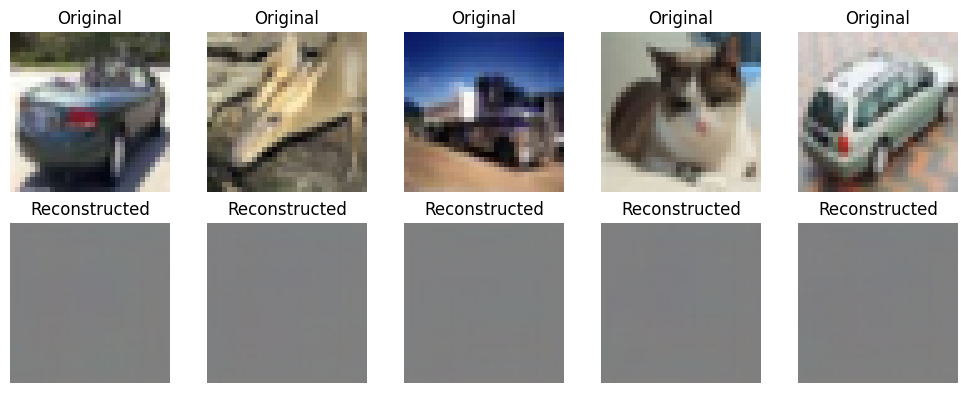

In [63]:
# Now, let's visualize some sample images along with their reconstructions to see how well the autoencoder is performing
# Select a few random images from the test set
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[random_indices]

# Generate reconstructions using the autoencoder
reconstructed_images = autoencoder.predict(sample_images)

# Plot the original and reconstructed images
plt.figure(figsize=(num_samples * 2, 4))

for i in range(num_samples):
    # Plot original images
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis('off')

    # Plot reconstructed images
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [66]:
#  implement the contrastive loss and reconstruction loss functions
def contrastive_loss(y_true, y_pred, margin=1):
    # Compute squared Euclidean distance between the embeddings
    squared_distance = tf.reduce_sum(tf.square(y_pred), axis=-1)
    
    # Compute contrastive loss
    loss = y_true * squared_distance + (1 - y_true) * tf.maximum(0, margin - squared_distance)
    
    # Compute mean loss
    loss = tf.reduce_mean(loss)
    
    return loss

# reconstruction loss
def reconstruction_loss(y_true, y_pred):
    # Compute mean squared error between the original and reconstructed images
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse


In [69]:
# Define separate input layers for encoder and decoder
encoder_input = layers.Input(shape=(32, 32, 3))
decoder_input = layers.Input(shape=(4, 4, 128))

# Get encoder output
encoder_output = encoder(encoder_input)

# Get decoder output
decoder_output = decoder(encoder_output)

# Define the autoencoder model
autoencoder = models.Model(inputs=encoder_input, outputs=decoder_output)

# Compile the model
autoencoder.compile(optimizer='adam', loss=reconstruction_loss)

# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, X_val)
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 288ms/step - loss: 0.0291 - val_loss: 0.0116
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - loss: 0.0108 - val_loss: 0.0093
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 266ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 280ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 94s 301ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 245ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 256ms/step - loss: 0.0054 - val_loss: 0.0052


In [73]:
autoencoder.summary()


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 4, 4, 128)      │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 32, 32, 3)      │       240,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,001,867 (3.82 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 667,912 (2.55 MB)

In [74]:
# Evaluate the model
test_loss = autoencoder.evaluate(X_test, X_test)

print("Test Loss:", test_loss)


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0052
Test Loss: 0.005194478202611208


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


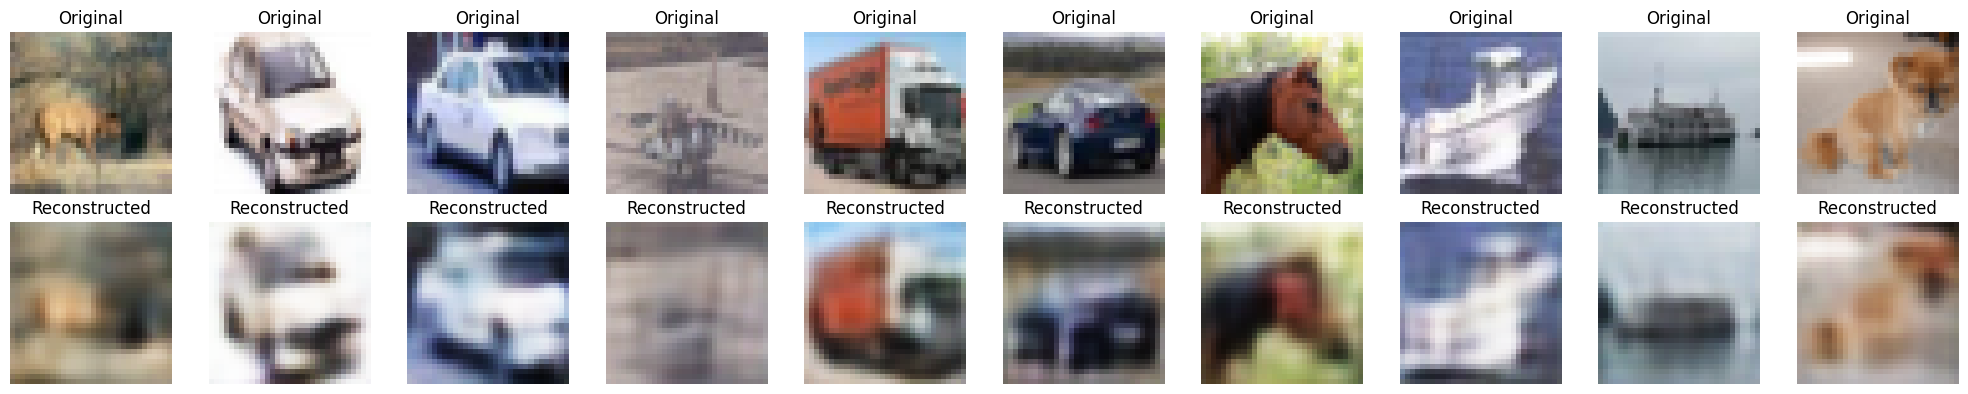

In [75]:
# Select some random images from the test set
num_images = 10
random_indices = np.random.randint(0, len(X_test), num_images)
sample_images = X_test[random_indices]

# Get the reconstructed images
reconstructed_images = autoencoder.predict(sample_images)

# Plot the original and reconstructed images
plt.figure(figsize=(num_images * 2, 4))

for i in range(num_images):
    # Original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [84]:
# Print the size of the images
print("Image size:", X_test[0].shape)


Image size: (32, 32, 3)


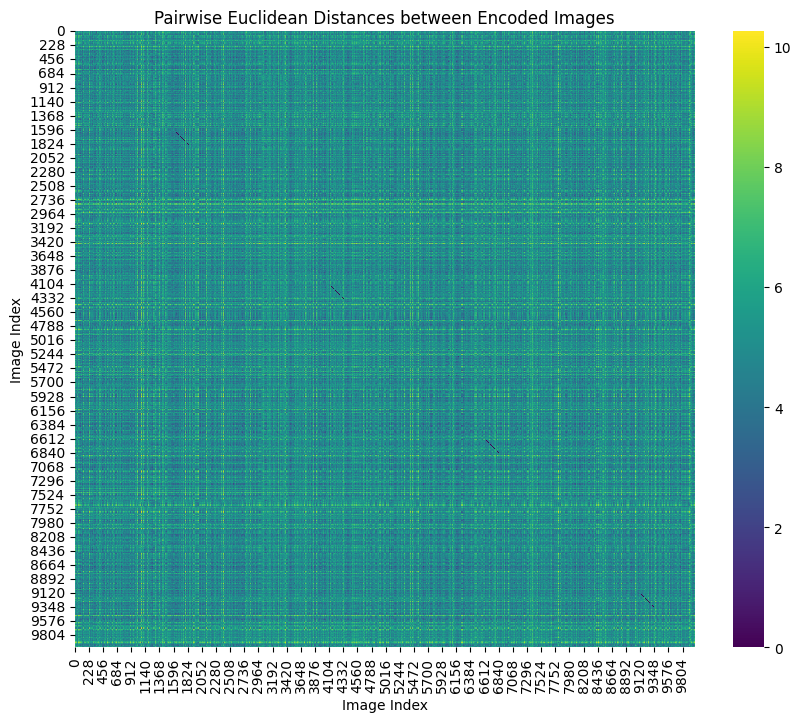

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import numpy.ma as ma

# Reshape encoded images to 2D array
encoded_imgs_flat = encoded_imgs.reshape(encoded_imgs.shape[0], -1)

# Calculate pairwise Euclidean distances between encoded images
distances = distance.cdist(encoded_imgs_flat, encoded_imgs_flat, 'euclidean')

# Create a mask for upper triangle
mask = np.triu(np.ones_like(distances, dtype=bool))

# Mask upper triangle
masked_distances = ma.masked_where(mask, distances)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(masked_distances, cmap='viridis')
plt.title('Pairwise Euclidean Distances between Encoded Images')
plt.xlabel('Image Index')
plt.ylabel('Image Index')
plt.show()


In [88]:
# Extract features using the encoder
encoded_imgs = encoder.predict(X_test)

# Check the shape of the encoded features
print("Encoded features shape:", encoded_imgs.shape)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Encoded features shape: (10000, 4, 4, 128)
